# 0. Load Packages

In [1]:
import math
import scipy.stats
import numpy as np
import pandas as pd
import doubleml as dml
from lightgbm import LGBMRegressor, LGBMClassifier
import datetime
from tqdm import tqdm
import plotly.graph_objects as go
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Enhanced plotting
import scipy
import statsmodels.api as sm
import networkx as nx
from IPython.display import Image, display
from itertools import combinations
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.base import clone
from scipy.stats import norm

import re

from pingouin import partial_corr

# Helpers

In [2]:
def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

# I. Identify Phenomenon & Target Theory
Gender wage gap & Human Capital Theory

# II. Formulate Focal Relationship
Human Capital -> Salary moderated by Gender

# Causal Machine Learning Process

## 1. Encode Existing Knowedge into DAG

/var/folders/1v/zk8xltnj3kz6cs0mjz5hgsh00000gr/T/ipykernel_16327/3352119625.py:29: DeprecationWarning: nx.nx_pydot.to_pydot depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  pdot = nx.nx_pydot.to_pydot(graph)


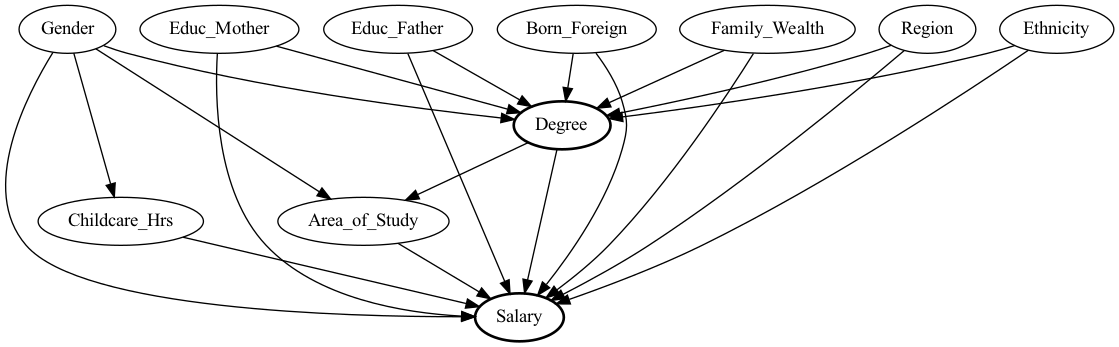

In [5]:
graph = nx.DiGraph()
graph.add_nodes_from(['Gender','Educ_Mother','Educ_Father','Born_Foreign','Family_Wealth','Childcare_Hrs','Region','Ethnicity'])
graph.add_nodes_from(['Degree','Salary'], style='bold')
graph.add_edges_from([('Degree','Salary'),
                      ('Gender','Degree'),
                      ('Gender','Salary'),
                      ('Family_Wealth','Salary'),
                      ('Family_Wealth','Degree'),
                      ('Region','Salary'),
                      ('Region','Degree'),
                      ('Educ_Father','Degree'),
                      ('Educ_Mother','Degree'),
                      ('Born_Foreign','Degree'),
                      ('Educ_Father','Salary'),
                      ('Educ_Mother','Salary'),
                      ('Born_Foreign','Salary'),
                      ('Childcare_Hrs','Salary'),
                      ('Ethnicity','Salary'),
                      ('Ethnicity','Degree'),

                      ('Gender','Area_of_Study'),
                      ('Degree','Area_of_Study'),
                      ('Area_of_Study','Salary'),
                      #('Prof_Experience','Hourly_Salary'),
                      #('College_Degree','Prof_Experience'),
                      ('Gender','Childcare_Hrs'),
                      #('Childcare_Hrs','Prof_Experience'),
                      ])
pdot = nx.nx_pydot.to_pydot(graph)
view_pydot(pdot)

## 1. Collect & Preprocess Data

In [6]:
states_parties = pd.read_csv('/Users/rudolfm/Documents - MTEC-SMI-322/Papers/Methods_Paper_CausalML/Data/US_states_Parties.csv')

In [7]:
psid_main = pd.read_csv('https://raw.githubusercontent.com/rudi-mac/causalml/main/psid_main.csv', index_col=0)
psid_main = pd.merge(psid_main, states_parties, on='State', how='left')
#psid_main = psid_main[psid_main['Study_Area']!='DK; NA; refused'].reset_index()
psid_main['Study_Area'] = np.where(psid_main['Study_Area'].str.contains('Engineering'),'Engineering',psid_main['Study_Area'])
psid_main

,Gender_Male,Ethnicity,Union_Part,Region,State,Prof_Experience_tot,Prof_Experience_ft,Education_Yrs,College_Degree,Bachelor_Degree,...,Main_Occupation,Occupation 2010 Description,Category,Main_Industry,Ref_Person,Occ_Category,Ind_Category,diff_prof_exp,Prof_Experience,Party
0,False,White,False,South,Tennessee,39.0,30.0,12,False,False,...,4110,Waiters and waitresses,Food Preparation and Serving Related Occupations,8680,True,Food Preparation and Serving Related Occupations,Accommodations and Food Services,9.0,34.5,Red
1,True,White,False,North Central,Kansas,18.0,13.0,12,False,False,...,6240,"Carpet, floor, and tile installers and finishers",Construction and Extraction Occupations,770,True,Construction and Extraction Occupations,Construction,5.0,15.5,Red
2,True,White,False,South,Tennessee,7.0,4.0,12,False,False,...,1560,Surveying and mapping technicians,Architecture and Engineering Occupations,7290,True,Architecture and Engineering Occupations,"Professional, Scientific, and Technical Services",3.0,5.5,Red
3,False,White,False,South,Tennessee,5.0,4.0,12,False,False,...,4610,Personal care aides,Personal Care and Service Occupations,8370,True,Personal Care and Service Occupations,Health Care and Social Assistance,1.0,4.5,Red
4,True,White,False,South,Tennessee,5.0,5.0,12,False,False,...,4700,First-line supervisors of retail sales workers,Sales and Related Occupations,5380,True,Sales and Related Occupations,Retail Trade,0.0,5.0,Red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4653,False,Black,False,West,California,4.0,4.0,16,False,False,...,430,"Managers, all other",Management Occupations,7390,False,Management Occupations,"Professional, Scientific, and Technical Services",0.0,4.0,Blue
4654,False,Black,False,South,Texas,2.0,1.0,12,False,False,...,4720,Cashiers,Sales and Related Occupations,5090,False,Sales and Related Occupations,Retail Trade,1.0,1.5,Red
4655,False,Black,False,South,Maryland,15.0,10.0,12,False,False,...,3649,Phlebotomists,Healthcare Support Occupations,8180,False,Healthcare Support Occupations,Health Care and Social Assistance,5.0,12.5,Blue
4656,False,Black,False,South,Texas,4.0,4.0,12,False,False,...,3420,Health practitioner support technologists and ...,Healthcare Practitioners and Technical Occupat...,4970,False,Healthcare Practitioners and Technical Occupat...,Retail Trade,0.0,4.0,Red


In [8]:
psid_main['Study_Area'].nunique()

44

In [9]:
# we need to convert categorical variables into one-hot encoded data
# Furthermore, we use the logarithm of salary to account for distribution skewness (e.g., https://kenbenoit.net/assets/courses/ME104/logmodels2.pdf#:~:text=URL%3A%20https%3A%2F%2Fkenbenoit.net%2Fassets%2Fcourses%2FME104%2Flogmodels2.pdf%0AVisible%3A%200%25%20)
psid_main_num = psid_main[['Gender_Male', 'Prof_Experience', 'Hourly_Salary','Masters_Degree','Bachelor_Degree','Childcare_Hrs','Born_Foreign','Wealth_abs','Educ_Father','Educ_Mother']].copy()
# one-hot encoding of categorical variables
psid_main_num = pd.concat([psid_main_num, pd.get_dummies(psid_main.Ethnicity, dtype=int)], axis=1)
psid_main_num = pd.concat([psid_main_num, pd.get_dummies(psid_main.Region, dtype=int)], axis=1)
psid_main_num = pd.concat([psid_main_num, pd.get_dummies(psid_main.Party, dtype=int)], axis=1)

psid_main_num = pd.concat([psid_main_num, pd.get_dummies(psid_main.Educ_Father, dtype=int)], axis=1)
psid_main_num = psid_main_num.rename(columns={1:'Father_0-5_grades',2:'Father_6-8_grades',3:'Father_9-11_grades',4:'Father_12_grades',5:'Father_12_grades_plus',6:'Father_Some_college',7:'Father_College_BA',8:'Father_College_advanced'})
psid_main_num = pd.concat([psid_main_num, pd.get_dummies(psid_main.Educ_Mother, dtype=int)], axis=1)
psid_main_num = psid_main_num.rename(columns={1:'Mother_0-5_grades',2:'Mother_6-8_grades',3:'Mother_9-11_grades',4:'Mother_12_grades',5:'Mother_12_grades_plus',6:'Mother_Some_college',7:'Mother_College_BA',8:'Mother_College_advanced'})

# remove one column per category to avoid "dummy trap"
#psid_main_num = psid_main_num.drop(['Other','South','Farming, Fishing, and Forestry Occupations','Mining, Quarrying, and Oil and Gas Extraction','Father_0-5_grades','Mother_0-5_grades','Wealth_Q1'], axis=1)

psid_main_num['Hourly_Salary_log'] = np.log(psid_main_num['Hourly_Salary'] )
psid_main_num['Gender_Male'] = psid_main_num['Gender_Male'].astype(int)
psid_main_num['Masters_Degree'] = psid_main_num['Masters_Degree'].astype(int)
psid_main_num['Bachelor_Degree'] = psid_main_num['Bachelor_Degree'].astype(int)

psid_main_num['Wealth_Quartiles'] = pd.qcut(psid_main_num['Wealth_abs'],4,labels=['Wealth_q1','Wealth_q2','Wealth_q3','Wealth_q4'])
psid_main_num = pd.concat([psid_main_num, pd.get_dummies(psid_main_num.Wealth_Quartiles, dtype=int)], axis=1)

# since you need a bachelor's degree to obtain a master's degree, we set all values of Bachelor_Degree to 1 if Masters_Degree is 1
psid_main_num.loc[psid_main_num['Masters_Degree'] == 1, 'Bachelor_Degree'] = 1

In [10]:
# summary statistics
sum_stat = psid_main_num.groupby('Gender_Male').agg(Count=('Bachelor_Degree','count'),
                                                    Hourly_Salary_mean=('Hourly_Salary','mean'),
                                                    Hourly_Salary_median=('Hourly_Salary','median'),
                                                    Bachelor_Degree=('Bachelor_Degree','sum'),
                                                    Prof_Exp=('Prof_Experience','mean'),
                                                    Region_West=('West','sum'),
                                                    Region_South=('South','sum'),
                                                    Region_Northeast=('Northeast','sum'),).transpose().rename(columns={0: 'Female',1:'Male'})
sum_stat = round(sum_stat,2)
sum_stat.rename({'Count':'# of Individuals',
                 'Hourly_Salary_mean':'Mean Hourly Salary [$]',
                 'Hourly_Salary_median':'Median Hourly Salary [$]',
                 'Bachelor_Degree':'Bachelor Degree [%]',
                 'Prof_Exp':'Mean Prof. Experience [Years]',
                 'Region_West':'Region West [%]',
                 'Region_South':'Region South [%]',
                 'Region_Northeast':'Region Northeast [%]',}, inplace=True)
sum_stat.loc['Bachelor Degree [%]',:] = round(100*sum_stat.loc['Bachelor Degree [%]',:] / (sum_stat.loc['# of Individuals','Female'] + sum_stat.loc['# of Individuals','Male']),2)
sum_stat.loc['Region West [%]',:] = round(100*sum_stat.loc['Region West [%]',:] / (sum_stat.loc['# of Individuals','Female'] + sum_stat.loc['# of Individuals','Male']),2)
sum_stat.loc['Region South [%]',:] = round(100*sum_stat.loc['Region South [%]',:] / (sum_stat.loc['# of Individuals','Female'] + sum_stat.loc['# of Individuals','Male']),2)
sum_stat.loc['Region Northeast [%]',:] = round(100*sum_stat.loc['Region Northeast [%]',:] / (sum_stat.loc['# of Individuals','Female'] + sum_stat.loc['# of Individuals','Male']),2)

#sum_stat.loc['# of Individuals','Female'] = round(sum_stat.loc['# of Individuals','Female'])
sum_stat

Gender_Male,Female,Male
# of Individuals,2206.00,2452.00
Mean Hourly Salary [$],25.49,33.30
Median Hourly Salary [$],19.24,25.00
Bachelor Degree [%],15.05,17.95
Mean Prof. Experience [Years],9.56,9.28
Region West [%],6.53,9.04
Region South [%],21.79,22.78
Region Northeast [%],5.78,6.91


In [12]:
a = psid_main_num[psid_main_num['Bachelor_Degree']==0]['Hourly_Salary'].mean()
b = psid_main_num[psid_main_num['Bachelor_Degree']==1]['Hourly_Salary'].mean()
print(round(a,2),round(b,2),(b-a)/a)

24.67 39.61 0.605334549954022


In [13]:
print(psid_main_num[psid_main_num['Gender_Male']==0].shape[0],
      psid_main_num[psid_main_num['Gender_Male']==1].shape[0])

2206 2452


In [14]:
print(psid_main_num[psid_main_num['Gender_Male']==0].shape[0]/psid_main_num.shape[0],
      psid_main_num[psid_main_num['Gender_Male']==1].shape[0]/psid_main_num.shape[0])

0.4735938170888793 0.5264061829111206


In [15]:
print(psid_main_num[psid_main_num['Bachelor_Degree']==0].shape[0],
psid_main_num[psid_main_num['Bachelor_Degree']==1].shape[0])

3121 1537


In [16]:
# summary statistics
sum_stat = psid_main_num.dropna().groupby(['Bachelor_Degree','Gender_Male']).agg(Count=('Bachelor_Degree','count'),
                                                    Hourly_Salary_mean=('Hourly_Salary','mean'),
                                                    Hourly_Salary_median=('Hourly_Salary','median'),
                                                    Hourly_Salary_std=('Hourly_Salary','std'),
                                                    Prof_Exp_mean=('Prof_Experience','mean'),
                                                    Prof_Exp_std=('Prof_Experience','std'),
                                                    Region_West=('West','sum'),
                                                    Region_South=('South','sum'),
                                                    Region_Northeast=('Northeast','sum'),
                                                    Region_Northcentral=('North Central','sum'),
                                                    Ethnic_Black=('Black','sum'),
                                                    Ethnic_White=('White','sum'),
                                                    Ethnic_Asian=('Asian','sum'),
                                                    Ethnic_Pacif=('Native Hawaiian or Pacific Islander','sum'),
                                                    Ethnic_Other=('Other','sum')).transpose().rename(columns={0: 'Female',1:'Male'},level=1).rename(columns={0: 'No Degree',1:'Bachelor Degree'},level=0)
sum_stat = round(sum_stat,2)
sum_stat.rename({'Count':'# of Individuals',
                 'Hourly_Salary_mean':'Mean Hourly Salary [$]',
                 'Hourly_Salary_median':'Median Hourly Salary [$]',
                 'Bachelor_Degree':'Bachelor Degree [%]',
                 'Prof_Exp':'Mean Prof. Experience [Years]',
                 'Region_West':'Region West [%]',
                 'Region_South':'Region South [%]',
                 'Region_Northeast':'Region Northeast [%]',
                 'Region_Northcentral':'Region North Central [%]',
                 'Ethnic_Black':'Ethnic Black [%]',
                 'Ethnic_White':'Ethnic White [%]',
                 'Ethnic_Asian':'Ethnic Asian [%]',
                 'Ethnic_Pacif':'Ethnic Pacif [%]',
                 'Ethnic_Other':'Ethnic Other [%]'}, inplace=True)
sum_stat.loc['Individuals [% of Total]',(['No Degree','Bachelor Degree'],['Female','Male'])] = round(100*sum_stat.loc['# of Individuals',(['No Degree','Bachelor Degree'],['Female','Male'])] / sum_stat.loc['# of Individuals',(['No Degree','Bachelor Degree'],['Female','Male'])],2)
sum_stat.loc['Region West [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] = round(100*sum_stat.loc['Region West [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] / sum_stat.loc['# of Individuals',(['No Degree','Bachelor Degree'],['Female','Male'])],2)
sum_stat.loc['Region South [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] = round(100*sum_stat.loc['Region South [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] / sum_stat.loc['# of Individuals',(['No Degree','Bachelor Degree'],['Female','Male'])],2)
sum_stat.loc['Region Northeast [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] = round(100*sum_stat.loc['Region Northeast [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] / sum_stat.loc['# of Individuals',(['No Degree','Bachelor Degree'],['Female','Male'])],2)
sum_stat.loc['Region North Central [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] = round(100*sum_stat.loc['Region North Central [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] / sum_stat.loc['# of Individuals',(['No Degree','Bachelor Degree'],['Female','Male'])],2)
sum_stat.loc['Ethnic Black [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] = round(100*sum_stat.loc['Ethnic Black [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] / sum_stat.loc['# of Individuals',(['No Degree','Bachelor Degree'],['Female','Male'])],2)
sum_stat.loc['Ethnic White [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] = round(100*sum_stat.loc['Ethnic White [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] / sum_stat.loc['# of Individuals',(['No Degree','Bachelor Degree'],['Female','Male'])],2)
sum_stat.loc['Ethnic Asian [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] = round(100*sum_stat.loc['Ethnic Asian [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] / sum_stat.loc['# of Individuals',(['No Degree','Bachelor Degree'],['Female','Male'])],2)
sum_stat.loc['Ethnic Pacif [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] = round(100*sum_stat.loc['Ethnic Pacif [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] / sum_stat.loc['# of Individuals',(['No Degree','Bachelor Degree'],['Female','Male'])],2)
sum_stat.loc['Ethnic Other [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] = round(100*sum_stat.loc['Ethnic Other [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] / sum_stat.loc['# of Individuals',(['No Degree','Bachelor Degree'],['Female','Male'])],2)
#sum_stat.loc['# of Individuals','Female'] = round(sum_stat.loc['# of Individuals','Female'])
sum_stat

Bachelor_Degree          No Degree          Bachelor Degree        
Gender_Male                 Female     Male          Female    Male
# of Individuals           1505.00  1616.00          701.00  836.00
Mean Hourly Salary [$]       22.38    26.80           32.16   45.84
Median Hourly Salary [$]     17.50    21.55           27.00   35.29
Hourly_Salary_std            33.76    26.50           28.83   50.73
Prof_Exp_mean                 9.88     9.66            8.87    8.55
Prof_Exp_std                  8.36     7.86            7.12    7.07
Region West [%]              13.29    16.15           14.84   19.14
Region South [%]             47.84    45.48           42.08   39.00
Region Northeast [%]         10.63    11.14           15.55   16.99
Region North Central [%]     28.04    26.79           27.39   24.52
Ethnic Black [%]             46.31    32.74           28.10   16.27
Ethnic White [%]             51.56    65.16           70.19   82.06
Ethnic Asian [%]              0.13     0.19            0.14    0.96
Ethnic Pacif [%]              0.07     0.06            0.00    0.12
Ethnic Other [%]              1.00     0.99            1.14    0.48
Individuals [% of Total]    100.00   100.00          100.00  100.00

In [17]:
round(100*sum_stat.loc['Region West [%]',(['No Degree','Bachelor Degree'],['Female','Male'])] / sum_stat.loc['# of Individuals',(['No Degree','Bachelor Degree'],['Female','Male'])],2)

Bachelor_Degree  Gender_Male
No Degree        Female         0.88
                 Male           1.00
Bachelor Degree  Female         2.12
                 Male           2.29
dtype: float64

In [19]:
# drop one category per group to avoid categorical dummy trap
# base category: male, white, no degree, US_born, Father_12_grades_plus, Mother_12_grades_plus, Wealth_q3, north central

columns = ['Gender_Male',
           'Asian', 'Black', 'Other', 'Native Hawaiian or Pacific Islander', #,'White'
           'Hourly_Salary_log',
           'Bachelor_Degree',
           #'Childcare_Hrs',
           'Born_Foreign',
            'Father_6-8_grades', 'Father_9-11_grades','Father_12_grades', 'Father_12_grades_plus', 'Father_Some_college','Father_College_BA', 'Father_College_advanced',#'Educ_Father',
           'Mother_6-8_grades', 'Mother_9-11_grades', 'Mother_12_grades','Mother_12_grades_plus', 'Mother_Some_college', 'Mother_College_BA','Mother_College_advanced',#'Educ_Mother',
           'Wealth_q1','Wealth_q2','Wealth_q4', #,'Wealth_q3','Wealth_abs',
           'South', 'Northeast', 'West', #,'North Central'
           #'Blue','Red' #,'Swing'
           ]

causal_df = psid_main_num[columns].copy()
causal_df = causal_df.loc[:,~causal_df.columns.duplicated()].copy()
causal_df = causal_df.reset_index(drop=True)
causal_df.rename({'West':'Region_West','Northeast':'Region_Northeast','South':'Region_South'},axis=1,inplace=True)
causal_df['Female'] = np.where(causal_df['Gender_Male']==1,0,1)
causal_df = causal_df.drop(['Gender_Male'],axis=1)
causal_df.rename({'Asian':'Ethnic_Asian','Black':'Ethnic_Black','Other':'Ethnic_Other','Native Hawaiian or Pacific Islander':'Ethnic_Hawaiian_Pac_Islander'},axis=1,inplace=True)

causal_df

,Ethnic_Asian,Ethnic_Black,Ethnic_Other,Ethnic_Hawaiian_Pac_Islander,Hourly_Salary_log,Bachelor_Degree,Born_Foreign,Father_6-8_grades,Father_9-11_grades,Father_12_grades,...,Mother_Some_college,Mother_College_BA,Mother_College_advanced,Wealth_q1,Wealth_q2,Wealth_q4,Region_South,Region_Northeast,Region_West,Female
0,0,0,0,0,0.916291,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,0,0,0,0,2.813411,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,2.803360,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,2.525729,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,3.217275,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4653,0,1,0,0,3.332205,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
4654,0,1,0,0,2.484907,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,1
4655,0,1,0,0,2.983153,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,1
4656,0,1,0,0,2.995732,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,1


In [20]:
covariates = causal_df.drop(['Female','Hourly_Salary_log'],axis=1).columns.to_list()

## Compute partial R-squared

## 2. Construct Interaction Terms

In [23]:
# Generate all possible combinations of two-way interactions
unique_values = causal_df.drop('Hourly_Salary_log',axis=1).columns
all_combinations_2w = list(combinations(unique_values, 2))
print(len(all_combinations_2w))

351


In [24]:
interaction_terms_2way = []
for combi in all_combinations_2w:
    column_name = combi[0]+':'+ combi[1]

    if combi[0][:6] != combi[1][:6]:
        #print(column_name)
        causal_df[column_name] = causal_df[combi[0]]*causal_df[combi[1]]
        interaction_terms_2way.append(column_name)
causal_df = causal_df.copy()
causal_df.shape

/var/folders/1v/zk8xltnj3kz6cs0mjz5hgsh00000gr/T/ipykernel_16327/1267174352.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  causal_df[column_name] = causal_df[combi[0]]*causal_df[combi[1]]
/var/folders/1v/zk8xltnj3kz6cs0mjz5hgsh00000gr/T/ipykernel_16327/1267174352.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  causal_df[column_name] = causal_df[combi[0]]*causal_df[combi[1]]
/var/folders/1v/zk8xltnj3kz6cs0mjz5hgsh00000gr/T/ipykernel_16327/1267174352.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usual

(4658, 325)

In [25]:
causal_df

,Ethnic_Asian,Ethnic_Black,Ethnic_Other,Ethnic_Hawaiian_Pac_Islander,Hourly_Salary_log,Bachelor_Degree,Born_Foreign,Father_6-8_grades,Father_9-11_grades,Father_12_grades,...,Wealth_q2:Region_Northeast,Wealth_q2:Region_West,Wealth_q2:Female,Wealth_q4:Region_South,Wealth_q4:Region_Northeast,Wealth_q4:Region_West,Wealth_q4:Female,Region_South:Female,Region_Northeast:Female,Region_West:Female
0,0,0,0,0,0.916291,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,2.813411,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,2.803360,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,2.525729,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,3.217275,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4653,0,1,0,0,3.332205,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4654,0,1,0,0,2.484907,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4655,0,1,0,0,2.983153,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4656,0,1,0,0,2.995732,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0


In [26]:
# Generate all possible combinations of three-way interactions
all_combinations_3w = list(combinations(unique_values, 3))
print(len(all_combinations_3w))

2925


In [28]:
interaction_terms_3way = []
causal_df_3w = causal_df.copy()
for combi in all_combinations_3w:
    column_name = combi[0] + ':' + combi[1] + ':' + combi[2]
    
    if (combi[0][:6] != combi[1][:6]) & (combi[0][:6] != combi[2][:6]) & (combi[1][:6] != combi[2][:6]):
        #print(column_name)
        causal_df_3w[column_name] = causal_df[combi[0]]*causal_df[combi[1]]*causal_df[combi[2]]
        interaction_terms_3way.append(column_name)
causal_df_3w = causal_df_3w.copy()
causal_df_3w.shape

/var/folders/1v/zk8xltnj3kz6cs0mjz5hgsh00000gr/T/ipykernel_16327/2876563383.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  causal_df_3w[column_name] = causal_df[combi[0]]*causal_df[combi[1]]*causal_df[combi[2]]
/var/folders/1v/zk8xltnj3kz6cs0mjz5hgsh00000gr/T/ipykernel_16327/2876563383.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  causal_df_3w[column_name] = causal_df[combi[0]]*causal_df[combi[1]]*causal_df[combi[2]]
/var/folders/1v/zk8xltnj3kz6cs0mjz5hgsh00000gr/T/ipykernel_16327/2876563383.py:8: PerformanceWarning: 

(4658, 2052)

In [30]:
pattern1 = r'.*Female.*'
matches = [text for text in causal_df_3w.columns.to_list() if re.search(pattern1, text, re.IGNORECASE)]
pattern2 = r'.*Bachelor_Degree.*'
matches = [text for text in matches if re.search(pattern2, text, re.IGNORECASE)]
print(len(matches))

26


In [33]:
causal_df_3w.shape

(4658, 2052)

In [35]:
#causal_df.to_csv('/Users/rudolfm/Documents - MTEC-SMI-322/R_Studio/Gender_Wage_Gap/causal_df.csv')

## 3. Specify Learners

In [38]:
ml_l = Lasso(fit_intercept=True, alpha=1) # Outcome Model: A machine learner for the nuisance function l0(X) = E[Y|X]
ml_m = Lasso(fit_intercept=True, alpha=1) # Treatment Model: A machine learner for the nuisance function m0(X) = E[D|X] 
ml_g = Lasso(fit_intercept=True) # A machine learner for the nuisance function g0(X) = E[Y-D*theta0|X]

par_grids = {'ml_l': {'alpha': np.arange(0.1, 1., 0.05)},
             'ml_m': {'alpha': np.arange(0.1, 1., 0.05)}}

# Select Possible Treatments

In [39]:
# drop all columns that are constant / dont have any variation
causal_df_3w.drop('Ethnic_Hawaiian_Pac_Islander:Bachelor_Degree:Female', axis=1 ,inplace=True)
matches.remove('Ethnic_Hawaiian_Pac_Islander:Bachelor_Degree:Female')

In [ ]:
# Construct treatment variables: 
# Main effects: Bachelor_Degree, Female
# 2-way interaction: Bachelor_Degree:Female  
# 3-way interactions: Bachelor_Degree:Female:X for various moderators X

treatment_variables = []

# Add main effects
treatment_variables.append('Bachelor_Degree')
treatment_variables.append('Female')

# Add 2-way interaction Bachelor_Degree:Female
if 'Bachelor_Degree:Female' in causal_df_3w.columns:
    treatment_variables.append('Bachelor_Degree:Female')
elif 'Female:Bachelor_Degree' in causal_df_3w.columns:
    treatment_variables.append('Female:Bachelor_Degree')
else:
    # Create it if it doesn't exist
    causal_df_3w['Bachelor_Degree:Female'] = causal_df_3w['Bachelor_Degree'] * causal_df_3w['Female']
    treatment_variables.append('Bachelor_Degree:Female')

# Add all 3-way interactions: Bachelor_Degree:Female:X
pattern1 = r'.*Female.*'
pattern2 = r'.*Bachelor_Degree.*'
for col in causal_df_3w.columns:
    if re.search(pattern1, col, re.IGNORECASE) and re.search(pattern2, col, re.IGNORECASE):
        # Check if it's a 3-way interaction (has 2 colons)
        if col.count(':') == 2:
            # Make sure it's not a duplicate and not already in the list
            if col not in treatment_variables:
                # Check that the column is not constant (has variation)
                if causal_df_3w[col].nunique() > 1:
                    treatment_variables.append(col)

print(f"Total treatment variables: {len(treatment_variables)}")
print(f"Main effects: Bachelor_Degree, Female")
print(f"2-way interaction: 1")
print(f"3-way interactions: {len(treatment_variables) - 3}")
print(f"\nTreatment variables: {treatment_variables}")

## 5. Fit Treatment & Outcome Model

In [ ]:
# Create DoubleMLData object with multiple treatments
# Y: log(Hourly_Salary)
# D: treatment variables (Bachelor_Degree, Female, and their interactions)
# X: all other covariates (use_other_treat_as_covariate=True means other treatments are also used as covariates)

print("Creating DoubleMLData object...")
print(f"Outcome variable: Hourly_Salary_log")
print(f"Treatment variables: {len(treatment_variables)} treatments")
print(f"All other columns will be used as covariates")

obj_dml_data = dml.DoubleMLData(causal_df_3w, 
                                y_col='Hourly_Salary_log', 
                                d_cols=treatment_variables,
                                use_other_treat_as_covariate=True)

print(f"\nDoubleMLData object created successfully!")
print(f"Number of observations: {obj_dml_data.n_obs}")
print(f"Number of covariates: {obj_dml_data.n_coefs}")

In [ ]:
# Create DoubleMLPLR object
# PLR = Partially Linear Regression model
# Model: Y = D*theta + g(X) + epsilon, where E[D|X] = m(X) + u
# We use Lasso for both nuisance functions (outcome and treatment models)

print("Creating DoubleMLPLR object...")
dml_plr = dml.DoubleMLPLR(obj_dml_data, 
                          ml_l=ml_l,  # Outcome model learner
                          ml_m=ml_m,  # Treatment model learner  
                          ml_g=None,  # Optional: learner for g(X) = E[Y-D*theta|X]
                          n_folds=5,  # 5-fold cross-fitting
                          n_rep=5)    # 5 repetitions for stability

print("DoubleMLPLR object created successfully!")

In [43]:
# hyperparameter tuning: penalty parameter lambda
#dml_plr.tune(par_grids, search_mode='grid_search')
#print(dml_plr.params)

In [ ]:
# Fit the DML model
print("Fitting DoubleMLPLR model...")
print("This may take a few minutes due to cross-fitting and multiple repetitions...")
dml_plr.fit()
print("\nModel fitted successfully!")

In [ ]:
# Display comprehensive DML results
print("="*80)
print("DOUBLE MACHINE LEARNING RESULTS - COMPREHENSIVE REPORT")
print("="*80)

# Get the summary
summary_df = dml_plr.summary
print("\n" + "="*80)
print("COEFFICIENT ESTIMATES")
print("="*80)
print(summary_df)

# Get confidence intervals
print("\n" + "="*80)
print("CONFIDENCE INTERVALS (95%)")
print("="*80)
conf_int_95 = dml_plr.confint(level=0.95)
print(conf_int_95)

# Get p-values
print("\n" + "="*80)
print("HYPOTHESIS TESTS (H0: theta = 0)")
print("="*80)
pvals = dml_plr.pval
print(f"Treatment Variables and P-values:")
for i, treat in enumerate(treatment_variables):
    print(f"{treat:50s} p-value: {pvals[i]:.6f}")

# Model diagnostics
print("\n" + "="*80)
print("MODEL DIAGNOSTICS")
print("="*80)
learner_eval = dml_plr.evaluate_learners()
print(f"\nOutcome Model (ml_l) RMSE: {learner_eval['ml_l'][0]:.6f}")
print(f"Treatment Model (ml_m) RMSE:")
for i, treat in enumerate(treatment_variables):
    rmse = learner_eval['ml_m'][i] if hasattr(learner_eval['ml_m'], '__getitem__') else learner_eval['ml_m']
    print(f"  {treat:50s} RMSE: {rmse:.6f}")

# Sensitivity analysis parameters
print("\n" + "="*80)
print("SENSITIVITY ANALYSIS")
print("="*80)
if hasattr(dml_plr, 'sensitivity_params') and dml_plr.sensitivity_params is not None:
    rv_values = dml_plr.sensitivity_params.get('rv', None)
    if rv_values is not None:
        print("Robustness Values (RV) - proportion of residual variance explained by unobserved confounder:")
        for i, treat in enumerate(treatment_variables):
            rv = rv_values[i] if hasattr(rv_values, '__getitem__') else rv_values
            print(f"  {treat:50s} RV: {rv*100:.2f}%")

# Key findings summary
print("\n" + "="*80)
print("KEY FINDINGS SUMMARY")
print("="*80)
print("\nStatistically significant effects (p < 0.05):")
sig_effects = summary_df[summary_df['P>|t|'] < 0.05]
if len(sig_effects) > 0:
    for idx in sig_effects.index:
        coef = sig_effects.loc[idx, 'coef']
        se = sig_effects.loc[idx, 'std err']
        pval = sig_effects.loc[idx, 'P>|t|']
        print(f"\n{idx}:")
        print(f"  Coefficient: {coef:.4f} (SE: {se:.4f}, p-value: {pval:.6f})")
        if coef > 0:
            print(f"  Interpretation: Positive effect on log(Hourly_Salary)")
        else:
            print(f"  Interpretation: Negative effect on log(Hourly_Salary)")
else:
    print("No statistically significant effects at p < 0.05 level")

print("\n" + "="*80)

In [ ]:
# Create detailed results dataframe for export/further analysis
results_detailed = pd.DataFrame({
    'treatment': treatment_variables,
    'coefficient': dml_plr.coef,
    'std_error': dml_plr.se,
    't_statistic': dml_plr.coef / dml_plr.se,
    'p_value': dml_plr.pval,
})

# Add confidence intervals
ci_95 = dml_plr.confint(level=0.95)
results_detailed['ci_lower_95'] = ci_95.iloc[:, 0].values
results_detailed['ci_upper_95'] = ci_95.iloc[:, 1].values

ci_99 = dml_plr.confint(level=0.99)
results_detailed['ci_lower_99'] = ci_99.iloc[:, 0].values
results_detailed['ci_upper_99'] = ci_99.iloc[:, 1].values

# Add significance indicators
results_detailed['sig_1pct'] = results_detailed['p_value'] < 0.01
results_detailed['sig_5pct'] = results_detailed['p_value'] < 0.05
results_detailed['sig_10pct'] = results_detailed['p_value'] < 0.10

# Add model diagnostics
learner_eval = dml_plr.evaluate_learners()
results_detailed['outcome_model_rmse'] = learner_eval['ml_l'][0]
if hasattr(learner_eval['ml_m'], '__getitem__'):
    results_detailed['treatment_model_rmse'] = [learner_eval['ml_m'][i] for i in range(len(treatment_variables))]
else:
    results_detailed['treatment_model_rmse'] = learner_eval['ml_m']

# Sort by p-value
results_detailed = results_detailed.sort_values('p_value').reset_index(drop=True)

# Display the dataframe
print("\n" + "="*80)
print("DETAILED RESULTS DATAFRAME (sorted by p-value)")
print("="*80)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)
print(results_detailed)

# Export to CSV (optional)
# results_detailed.to_csv('dml_results_detailed.csv', index=False)
# print("\nResults exported to 'dml_results_detailed.csv'")

## 6. Perform Sensitivity Analysis

/var/folders/1v/zk8xltnj3kz6cs0mjz5hgsh00000gr/T/ipykernel_16327/4108696294.py:28: DeprecationWarning: nx.nx_pydot.to_pydot depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  pdot = nx.nx_pydot.to_pydot(graph)


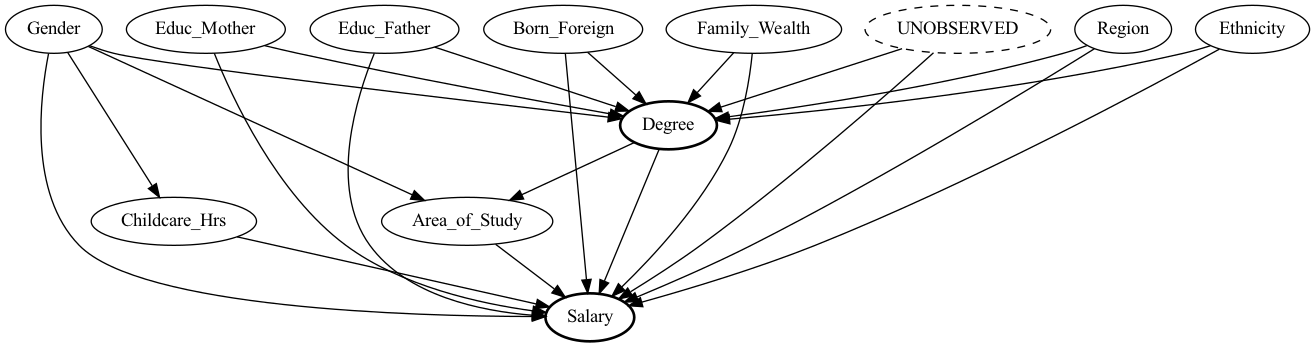

In [46]:
graph = nx.DiGraph()
graph.add_nodes_from(['Gender','Educ_Mother','Educ_Father','Born_Foreign','Family_Wealth','Childcare_Hrs'])
graph.add_nodes_from(['Degree','Salary'], style='bold')
graph.add_nodes_from(['UNOBSERVED'], style='dashed')
graph.add_edges_from([('Degree','Salary'),
                      ('Gender','Degree'),
                      ('Gender','Salary'),
                      ('Family_Wealth','Salary'),
                      ('Family_Wealth','Degree'),
                      ('Region','Salary'),
                      ('Region','Degree'),
                      ('Educ_Father','Degree'),
                      ('Educ_Mother','Degree'),
                      ('Born_Foreign','Degree'),
                      ('Educ_Father','Salary'),
                      ('Educ_Mother','Salary'),
                      ('Born_Foreign','Salary'),
                      ('Childcare_Hrs','Salary'),
                      ('Ethnicity','Salary'),
                      ('Ethnicity','Degree'),
                      ('Gender','Area_of_Study'),
                      ('Degree','Area_of_Study'),
                      ('Area_of_Study','Salary'),
                      ('UNOBSERVED','Salary'),
                      ('UNOBSERVED','Degree'),
                      ('Gender','Childcare_Hrs'),
                      ])
pdot = nx.nx_pydot.to_pydot(graph)
view_pydot(pdot)

In [47]:
dml_plr.sensitivity_analysis()

In [48]:
conf_int_df = dml_plr.bootstrap().confint(joint=True,level=0.999)
p_val_df = dml_plr.p_adjust()

In [49]:
conf_int_df

,0.1 %,100.0 %
Bachelor_Degree:Female,0.082020,0.283317
Ethnic_Asian:Bachelor_Degree:Female,0.290529,0.384041
Ethnic_Black:Bachelor_Degree:Female,-0.067615,0.258283
Ethnic_Other:Bachelor_Degree:Female,-0.517985,1.008980
Bachelor_Degree:Born_Foreign:Female,-0.600390,1.234657
Bachelor_Degree:Father_6-8_grades:Female,-0.476293,1.209810
Bachelor_Degree:Father_9-11_grades:Female,-0.415868,0.333222
Bachelor_Degree:Father_12_grades:Female,-0.103307,0.284016
Bachelor_Degree:Father_12_grades_plus:Female,-0.280900,0.441676
Bachelor_Degree:Father_Some_college:Female,-0.044449,0.355655


In [50]:
p_val_df

,thetas,pval
Bachelor_Degree:Female,0.182679,0.000
Ethnic_Asian:Bachelor_Degree:Female,0.338109,0.000
Ethnic_Black:Bachelor_Degree:Female,0.095777,0.104
Ethnic_Other:Bachelor_Degree:Female,0.245033,0.640
Bachelor_Degree:Born_Foreign:Female,0.323558,0.588
Bachelor_Degree:Father_6-8_grades:Female,0.366262,0.364
Bachelor_Degree:Father_9-11_grades:Female,-0.041740,0.978
Bachelor_Degree:Father_12_grades:Female,0.090986,0.292
Bachelor_Degree:Father_12_grades_plus:Female,0.080388,0.854
Bachelor_Degree:Father_Some_college:Female,0.155603,0.006


In [51]:
result_df = p_val_df.copy()
result_df['0.1 %'] = conf_int_df['0.1 %']
result_df['99.9 %'] = conf_int_df['100.0 %']
result_df['RV_%'] = dml_plr.sensitivity_params['rv']
result_df['RV_%'] = round(result_df['RV_%']*100,2)
result_df['ML_Outcome_RMSE'] = dml_plr.evaluate_learners()['ml_l'][0]
result_df['ML_Treatment_RMSE'] = dml_plr.evaluate_learners()['ml_m'][0]

result_df

,thetas,pval,0.1 %,99.9 %,RV_%,ML_Outcome_RMSE,ML_Treatment_RMSE
Bachelor_Degree:Female,0.182679,0.000,0.082020,0.283317,10.32,0.603115,0.357644
Ethnic_Asian:Bachelor_Degree:Female,0.338109,0.000,0.290529,0.384041,0.82,0.603115,0.014654
Ethnic_Black:Bachelor_Degree:Female,0.095777,0.104,-0.067615,0.258283,3.15,0.603115,0.201278
Ethnic_Other:Bachelor_Degree:Female,0.245033,0.640,-0.517985,1.008980,1.67,0.603115,0.041421
Bachelor_Degree:Born_Foreign:Female,0.323558,0.588,-0.600390,1.234657,2.33,0.603115,0.043915
Bachelor_Degree:Father_6-8_grades:Female,0.366262,0.364,-0.476293,1.209810,3.80,0.603115,0.063752
Bachelor_Degree:Father_9-11_grades:Female,-0.041740,0.978,-0.415868,0.333222,0.59,0.603115,0.085141
Bachelor_Degree:Father_12_grades:Female,0.090986,0.292,-0.103307,0.284016,2.97,0.603115,0.199829
Bachelor_Degree:Father_12_grades_plus:Female,0.080388,0.854,-0.280900,0.441676,1.08,0.603115,0.081331
Bachelor_Degree:Father_Some_college:Female,0.155603,0.006,-0.044449,0.355655,4.26,0.603115,0.168374


In [52]:
result_df

,thetas,pval,0.1 %,99.9 %,RV_%,ML_Outcome_RMSE,ML_Treatment_RMSE
Bachelor_Degree:Female,0.182679,0.000,0.082020,0.283317,10.32,0.603115,0.357644
Ethnic_Asian:Bachelor_Degree:Female,0.338109,0.000,0.290529,0.384041,0.82,0.603115,0.014654
Ethnic_Black:Bachelor_Degree:Female,0.095777,0.104,-0.067615,0.258283,3.15,0.603115,0.201278
Ethnic_Other:Bachelor_Degree:Female,0.245033,0.640,-0.517985,1.008980,1.67,0.603115,0.041421
Bachelor_Degree:Born_Foreign:Female,0.323558,0.588,-0.600390,1.234657,2.33,0.603115,0.043915
Bachelor_Degree:Father_6-8_grades:Female,0.366262,0.364,-0.476293,1.209810,3.80,0.603115,0.063752
Bachelor_Degree:Father_9-11_grades:Female,-0.041740,0.978,-0.415868,0.333222,0.59,0.603115,0.085141
Bachelor_Degree:Father_12_grades:Female,0.090986,0.292,-0.103307,0.284016,2.97,0.603115,0.199829
Bachelor_Degree:Father_12_grades_plus:Female,0.080388,0.854,-0.280900,0.441676,1.08,0.603115,0.081331
Bachelor_Degree:Father_Some_college:Female,0.155603,0.006,-0.044449,0.355655,4.26,0.603115,0.168374


In [53]:
result_df[result_df['pval']<0.001]

,thetas,pval,0.1 %,99.9 %,RV_%,ML_Outcome_RMSE,ML_Treatment_RMSE
Bachelor_Degree:Female,0.182679,0.0,0.082020,0.283317,10.32,0.603115,0.357644
Ethnic_Asian:Bachelor_Degree:Female,0.338109,0.0,0.290529,0.384041,0.82,0.603115,0.014654
Bachelor_Degree:Father_College_BA:Female,0.242766,0.0,0.075172,0.409406,7.41,0.603115,0.190712
Bachelor_Degree:Father_College_advanced:Female,0.214035,0.0,-0.006629,0.434698,5.07,0.603115,0.146414
Bachelor_Degree:Mother_College_BA:Female,0.204329,0.0,0.043080,0.365578,6.03,0.603115,0.183240
Bachelor_Degree:Mother_College_advanced:Female,0.228492,0.0,0.022071,0.430960,5.74,0.603115,0.155839
Bachelor_Degree:Wealth_q4:Female,0.353016,0.0,0.201846,0.504851,11.47,0.603115,0.206588
Bachelor_Degree:Region_South:Female,0.125519,0.0,-0.007661,0.258699,4.95,0.603115,0.243625
Bachelor_Degree:Region_Northeast:Female,0.324834,0.0,0.098323,0.550950,7.84,0.603115,0.151191
Bachelor_Degree,0.452031,0.0,0.371141,0.532646,31.25,0.603115,0.470458


In [55]:
#p_val_df = dml_plr.p_adjust('romano-wolf')

# Visuals

In [57]:
# Model: log(Salary) = theta*Bachelor_Degree + b0 + b1*Gender_Male + b2*Bachelor_Degree*Female + b3*Bachelor_Degree*Female*Wealthq4 + rest
 
# Example regression coefficients
beta_0 = 0  # Intercept
beta_1 = result_df.loc['Bachelor_Degree','thetas']  
beta_2 = result_df.loc['Female','thetas']
beta_3 = result_df.loc['Bachelor_Degree:Female','thetas']  # Coefficient for interaction 

In [58]:
# Generate a grid of values for X1 and X2
Bachelor_Degree = np.linspace(0, 1)  # Range for X1
Gender_Male = np.linspace(0, 1)  # Range for X2
X1_grid, X2_grid = np.meshgrid(Bachelor_Degree, Gender_Male)

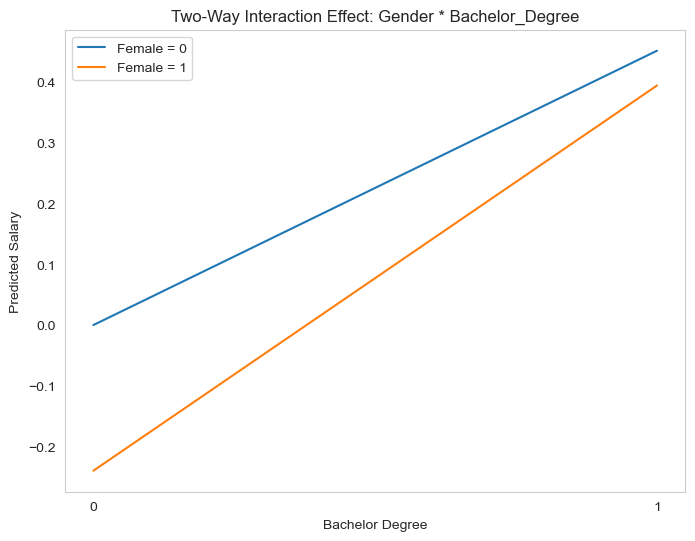

In [60]:
# Fix X2 at different levels and plot the effect of X1
Gender_fixed = [0, 1]  # Fixed levels of X2

plt.figure(figsize=(8, 6))
for gender in Gender_fixed:
    Y_line = beta_0 + beta_1 * Bachelor_Degree + beta_2 * gender + beta_3 * (Bachelor_Degree * gender)
    plt.plot(Bachelor_Degree, Y_line, label=f'Female = {gender}')

plt.xlabel('Bachelor Degree')
plt.ylabel('Predicted Salary')
plt.title('Two-Way Interaction Effect: Gender * Bachelor_Degree')
plt.legend()
plt.xticks(np.arange(0, 1.1, step=1))
#plt.yticks(np.arange(0, 1.1, step=0.2))
plt.grid(False)
plt.show()

In [ ]:
# -----------------------------------------------------------------------------
# EXPECTED INPUT
# -----------------------------------------------------------------------------
# df is a pandas DataFrame that contains at least:
#   - 'term': string name of a coefficient (e.g., 'Bachelor_Degree', 
#             'Bachelor_Degree:Female', 'Bachelor_Degree:Female:Wealth_Q4',
#             'Bachelor_Degree:Wealth_Q4', etc.)
#   - 'thetas': float coefficient value
#
# If your dataframe column with names is not 'term', change TERM_COL below.
# -----------------------------------------------------------------------------

# Example: df = pd.read_csv('your_coefficients.csv')  # Ensure it has 'term' and 'thetas'
# For demonstration, we assume `df` already exists in memory.

TERM_COL = 'term'          # column with coefficient names
COEF_COL = 'thetas'        # column with coefficient values

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------
BACHELOR_TOKEN_CANDIDATES = ['Bachelor_Degree', 'Degree']  # tries these (first match is used)
FEMALE_TOKEN_CANDIDATES   = ['Female', 'Gender_Female', 'female', 'F']  # tries these
# If your moderator levels include separators (e.g., 'Wealth_Q4' or 'Region_NE'), they will be used as labels.

# -----------------------------------------------------------------------------
# UTILITIES
# -----------------------------------------------------------------------------
def get_coef(df, name):
    """Return coefficient for exact term name, or 0.0 if absent."""
    row = df.loc[df[TERM_COL] == name, COEF_COL]
    return float(row.iloc[0]) if len(row) == 1 else 0.0

def first_existing_token(candidates, in_series):
    """Return the first token from candidates that appears as a standalone term or as a prefix in any interaction."""
    terms = set(in_series.unique())
    for tok in candidates:
        # standalone
        if tok in terms:
            return tok
        # as part of interactions
        pattern = re.compile(rf'(^|:)({re.escape(tok)})(:|$)')
        if any(bool(pattern.search(t)) for t in terms):
            return tok
    return None

def parse_three_way_terms(df, bachelor_tok, female_tok):
    """
    Identify 3-way interactions of the form:
        bachelor_tok : female_tok : moderator_level
    or in any order; we normalize by splitting on ':' and checking membership.

    Returns a dict:
        moderator_level -> {
            't_bd_f_m': coef of BD:Female:ModeratorLevel,
            't_bd_m':   coef of BD:ModeratorLevel (two-way),
        }
    and a set of all raw moderator level tokens discovered.
    """
    three_way = {}
    terms = df[TERM_COL].tolist()

    # Build lookup for quick access
    coef_map = dict(zip(df[TERM_COL], df[COEF_COL]))

    for t in terms:
        parts = t.split(':')
        if len(parts) == 3:
            parts_set = set(parts)
            if bachelor_tok in parts_set and female_tok in parts_set:
                # moderator is the remaining token
                mod = [p for p in parts if p not in (bachelor_tok, female_tok)][0]
                # normalized key for 3-way
                # retrieve coef
                t_bd_f_m = coef_map.get(t, 0.0)
                # also attempt to find the matching two-way BD:Mod (order-agnostic)
                twonames = [f"{bachelor_tok}:{mod}", f"{mod}:{bachelor_tok}"]
                t_bd_m = 0.0
                for tw in twonames:
                    if tw in coef_map:
                        t_bd_m = coef_map[tw]
                        break
                three_way[mod] = {'t_bd_f_m': float(t_bd_f_m), 't_bd_m': float(t_bd_m)}
    return three_way

# -----------------------------------------------------------------------------
# MAIN COMPUTATION
# -----------------------------------------------------------------------------
def compute_effects_matrix(df):
    # Identify canonical tokens actually used in the dataframe
    bachelor_tok = first_existing_token(BACHELOR_TOKEN_CANDIDATES, df[TERM_COL])
    female_tok   = first_existing_token(FEMALE_TOKEN_CANDIDATES, df[TERM_COL])

    if bachelor_tok is None:
        raise ValueError("Could not find a bachelor/degree token in coefficient names.")
    if female_tok is None:
        raise ValueError("Could not find a female token in coefficient names.")

    # Core coefficients
    beta_bd       = get_coef(df, bachelor_tok)                                 # β(BD)
    beta_bd_f     = get_coef(df, f"{bachelor_tok}:{female_tok}") or get_coef(df, f"{female_tok}:{bachelor_tok}")  # β(BD×Female)

    # Parse 3-way interactions and companion 2-way BD:Mod terms
    mods = parse_three_way_terms(df, bachelor_tok, female_tok)

    # Construct matrix: rows = moderator levels, cols = ['Men', 'Women']
    moderators = sorted(mods.keys())
    mat = np.zeros((len(moderators), 2), dtype=float)

    for i, mod in enumerate(moderators):
        beta_bd_m    = mods[mod]['t_bd_m']      # β(BD×mod)
        beta_bd_f_m  = mods[mod]['t_bd_f_m']    # β(BD×Female×mod)

        # Men effect at mod level m: β(BD) + β(BD×m)
        men = beta_bd + beta_bd_m

        # Women effect at mod level m: men + β(BD×Female) + β(BD×Female×m)
        women = men + beta_bd_f + beta_bd_f_m

        mat[i, 0] = men
        mat[i, 1] = women

    return moderators, mat

# -----------------------------------------------------------------------------
# PLOTTING
# -----------------------------------------------------------------------------
def plot_heatmap(moderators, mat, title="Effect of Bachelor’s Degree by Gender and Moderator",
                 cbar_label="Estimated effect (β)", fmt="{:.2f}", outfile=None):
    """
    Render a single heatmap (no subplots) with annotations.
    Columns: Men, Women. Rows: moderator levels.
    """
    fig, ax = plt.subplots(figsize=(10, max(4, 0.5*len(moderators) + 2)))  # height scales with number of rows

    # Heatmap
    im = ax.imshow(mat, aspect='auto')
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(cbar_label, rotation=90, labelpad=10)

    # Axis ticks and labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Men", "Women"])
    ax.set_yticks(np.arange(len(moderators)))
    ax.set_yticklabels(moderators)

    # Title and axes
    ax.set_title(title, pad=14)
    ax.set_xlabel("Gender")
    ax.set_ylabel("Third moderator level")

    # Gridlines for readability
    ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(moderators), 1), minor=True)
    ax.grid(which="minor", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Annotations
    for i in range(len(moderators)):
        for j in range(2):
            ax.text(j, i, fmt.format(mat[i, j]),
                    ha="center", va="center")

    fig.tight_layout()

    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches='tight')
    plt.show()

# -----------------------------------------------------------------------------
# EXECUTION (uncomment the following lines when df is available)
# -----------------------------------------------------------------------------
# moderators, mat = compute_effects_matrix(df)
# plot_heatmap(moderators, mat,
#              title="Overall Effect of Bachelor’s Degree by Gender across Moderator Levels",
#              cbar_label="Estimated effect (β)",
#              fmt="{:.2f}",
#              outfile="bachelors_effect_heatmap.png")